In [8]:
import numpy as np
import matplotlib.pyplot as plt

Tricky Ideas:
- Need to maintain a notion of time from initialization for training
- Need to maintain a notion of time while fitting and initializing

Use Cases would be:
- Train on a bunch of losses
- Train on a bunch of losses, then iteratively predict and train at each time step 
- Train on a bunch of losses, then iteratively predict and train at each time step 

Cases not considered:
- Features coming in at unequal times (in this case we would need to sample the data at equal times)

https://www.cs.princeton.edu/~rlivni/cos511/lectures/lect18.pdf

In [9]:
#Loss Functions
def se(actual,expected):
    """
    Will return the squared error between the two arguments
    """
    return np.power(np.subtract(actual,expected),2)

def mse(actual,expected):
    """
    Will return the mean squared error between the two arguments
    """
    return np.mean(se(actual,expected))

In [10]:
def _choose_from_distribution(axis_weights,sample_size=1):
        """
        Parameters
        ----------
        axis_weights: np.array() 1-D Array

        Returns
        -------
        np.array() with indices chosen according to the probability distribution defined by the axis weights

        Functional Code
        ---------------
            weights = abs(np.random.randn(10))
            weights/=np.sum(weights)
            bins = np.cumsum(weights)
            selections = np.random.uniform(size=10)

        Test Code
        ---------
            a = choosing_with_respect_to_prob_dist([1,2,3],sample_size=10000)
            print("Should be around .16: {}".format(np.sum(a==0)/10000))
            print("Should be around .33: {}".format(np.sum(a==1)/10000))
            print("Should be around .50: {}".format(np.sum(a==2)/10000))
        """
        weights = axis_weights/np.sum(axis_weights)
        bins = np.cumsum(weights)

        selections = np.random.uniform(size=sample_size)
        indices = [bisect.bisect_left(bins,s) for s in selections]

        return np.array(indices)
    
def _set_uniform(n):
        return np.ones(n)/n
    
def _define_epsilon(n,T,a=1):
    """
    Calculates a factor that is used in determining loss in the hedge algorithm

    Args:
        n (int): number of experts present
        T (int): number of time steps taken
        a (float): value that we can use to scale our epsilon
    Return:
        epsilon (float): the theoretical episilon, but which can be customized by a
    """

    return np.sqrt(np.log(n)/T)*a

# Hedge Algorithm with Doubling Trick

In [11]:
class OnlineExperts(object):

    def __init__(self,**kwargs):
        pass
    def _predict(self, expert_predictions):
        pass
    def _update(self, expert_predictions, actual_values, loss_func = se):
        pass

In [13]:
class OnlineHedge(OnlineExperts):

    def __init__(self,n=10,T=10,a=1):
        self.n = n
        self.T = T
        self.a = a
        self.weights = _set_uniform(n)
        self.epsilon = _define_epsilon(self.n,self.T,a=a)
        
        self.time = 0
        
    def _predict(self,expert_predictions):
        """
        Weights the expert predictions into a single prediction based on the weights that have been calculated by the
        hedge algorithm

        Args:
            expert predictions (np.array) (pred.float): np.array with the expert predictions

        Returns:
            a value for prediction based on the inputs of the experts and their respective weights.
        """
        choosen_prediction = expert_predictions[_choose_from_distribution(self.weights,sample_size=1)]
        
        return chosen_prediction
    
    
    def _update(self, expert_predictions, actual_values, loss_func = se):
        pass
        
    def _modify_weights(self,new_array):
        self.weights = self.weights * new_array
        self.weights /= np.sum(self.weights)

In [27]:
class OnlineHedgeDoubling(OnlineHedge):

    def __init__(self,n=10,T=10,a=1):
        self.n = n
        self.T = T
        self.a = a
        self.weights = _set_uniform(n)
        self.epsilon = _define_epsilon(self.n,self.T,a=a)
        
        self.time = 0
    
    def _update(self, expert_predictions, actual_values, loss_func = se):
        """
        """
        assert expert_predictions.shape[1]==len(actual_values), "Time Dimension Matches"
        time_length = expert_predictions.shape[1]
        
        total_time = time_length+self.time
        
        a = int(np.floor(np.log2(total_time/self.T)))
        splits = [self.T*2**(i)-self.time for i in range(a)]
        # negative indices are ignored
        splits = list(filter(lambda x: x>=0,splits))
        partitions = np.split(np.arange(total_time-self.time),splits)
        
        for i in range(len(partitions)):
            self.time+=len(partitions[i])
            
#             print(partitions[i])
#             print(self.time)
            
            if self.time>self.T:
                self.T = 2*self.T
                self.epsilon = _define_epsilon(self.n,self.T,self.a)
                
            losses = np.array([loss_func(expert_predictions[:,part], actual_values[part]) for part in partitions[i]])
            f = lambda x: np.exp(-self.epsilon*x)
            self._modify_weights(f(losses))

In [ ]:
class OnlineHedgeIncrementalTime(OnlineHedge):

    def __init__(self,n=10,T=None,a=1):
        super().__init__(n=10,T=None,a=1)
        self.loss = 0
    def _update(self, expert_predictions, actual_values, loss_func = se):
        """
        """
        assert expert_predictions.shape[1]==len(actual_values), "Time Dimension Matches"
        time_length = expert_predictions.shape[1]
        
        total_time = time_length+self.time
        
        for i in range(len(time_length)):
            self.time+=1
            epsilon = _define_epsilon(self.n,self.time,self.a)
            losses = loss_func(expert_predictions[:,i], actual_values[i])
            f = lambda x: np.exp(-epsilon*x)
            self._modify_weights(np.prod(f(losses),0))

In [26]:
np.prod?

In [15]:
time = 0

In [19]:
total_time = 10

In [22]:
times = np.arange(time,time+total_time)+1

In [25]:
np.array(list(map(lambda x: _define_epsilon(10,x), times)))

array([1.51742713, 1.07298301, 0.87608696, 0.75871356, 0.67861404,
       0.61948703, 0.57353355, 0.53649151, 0.50580904, 0.47985259])

# Default (One Update) Test

In [5]:
test1 = OnlineHedge(n=10,T=20,a=1)

In [6]:
expert_predictions = np.random.randn(10,20)

In [7]:
actual_values = np.random.randn(20)

In [8]:
test1._update(expert_predictions,actual_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
20


In [9]:
test1.time

20

# (Multiple) Update Test

In [10]:
test2 = OnlineHedge(n=10,T=20,a=1)
expert_predictions = np.random.randn(10,20)
actual_values = np.random.randn(20)
test2._update(expert_predictions,actual_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
20


In [11]:
test2.time

20

In [12]:
test2._update(expert_predictions,actual_values)

[]
20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
40


In [13]:
test2.time

40

In [14]:
test2.epsilon

0.23992629560940407

# Negative Splits

In [15]:
test3 = OnlineHedge(n=10,T=20,a=1)
expert_predictions = np.random.randn(10,20)
actual_values = np.random.randn(20)

In [16]:
test3._update(expert_predictions,actual_values)
test3._update(expert_predictions,actual_values)
test3._update(expert_predictions,actual_values)
test3._update(expert_predictions,actual_values)
test3._update(expert_predictions,actual_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
20
[]
20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
40
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
60
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
80
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
100


In [17]:
test3.epsilon

0.11996314780470203

In [18]:
test3.time

100

# Checking Epsilon Updates

In [19]:
test4 = OnlineHedge(n=10,T=20,a=1)
expert_predictions = np.random.randn(10,13)
actual_values = np.random.randn(13)

In [20]:
test4._update(expert_predictions,actual_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
13


In [21]:
test4._update(expert_predictions,actual_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
26


In [22]:
expert_predictions = np.random.randn(10,14)
actual_values = np.random.randn(14)

In [23]:
test4._update(expert_predictions,actual_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
40


In [24]:
test4.epsilon

0.23992629560940407

In [25]:
expert_predictions = np.random.randn(10,40)
actual_values = np.random.randn(40)

In [26]:
test4._update(expert_predictions,actual_values)

[]
40
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
80


In [27]:
test4.epsilon

0.1696535106103778

In [28]:
test4.time

80

# Normal Hedge

In [29]:
# Need to ensure that the loss lies in an interval of length 1

In [ ]:
class OnlineHedge(object):

    def __init__(self,n=10,T=10,a=1):
        self.R = np.zeros(n)
        self.weights = _set_uniform(n)
        
        self.time = 0
    def _predict(self, expert_predictions):
        choosen_prediction = expert_predictions[_choose_from_distribution(self.weights,sample_size=1)]
        return chosen_prediction
    
    def _update(self, expert_predictions, actual_values, loss_func = se):
        
        assert expert_predictions.shape[1]==len(actual_values), "Time Dimension Matches"
        
        time_length = expert_predictions.shape[1]
        total_time = time_length+self.time
        
        for i in range(len(expert_predictions)):
            loss_vector = np.array([loss_fun(prediction,actual_values) for prediction in expert_predictions[:,i]])
            average_loss = np.dot(self.weights,loss_vector)
            
            instant_regret = (average_loss - loss_vector)
            self.R += instant_regret
            
            self._update_weights()
    
    def _update_weights(self):
        
        # Calculating Normalizing Constant
        R_plus = list(map(lambda x: 0 if 0 > x else x , self.R))
        
        low_c = (min(R_plus)**2)/2
        high_c = (max(R_plus)**2)/2
        pot = lambda c: np.mean(np.exp((R_plus**2)/(2*c)))-np.e
        
        c_t = bisection(low_c,high_c,pot)
        
        # Calculating Probabilities
        prob = lambda r, c_t: (x/c_t)*np.exp((r**2)/(2*c_t))
        
        self.weights = np.array([prob(r,c_t) for r in R_plus])
        self.weights /= np.sum(self.weights)
        
        
def bisection(low,high,function,threshold=1e-8):
    left = low
    right = high
    
    if function(low)>0:
        left = high
        right = low
    
    while abs(left-right)>1e-8:
        mid = (left+right)/2
        print(mid)
        if function(mid)>0:
            right=mid
        else:
            left=mid
            
    return (left+right)/2

In [34]:
a = np.array([1,21,-1,21,-5])

In [39]:
b = list(map(lambda x: 0 if 0 > x else x , a))

In [47]:
# Low
low = (min(b)**2)/2

In [48]:
# high
high = (max(b)**2)/2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


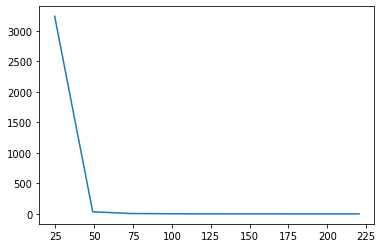

In [60]:
plt.plot(np.linspace(low,high,10), [pot(element) for  element in np.linspace(low,high,10)])

In [59]:
pot = lambda c: np.mean(np.exp((a**2)/(2*c)))-np.e

In [95]:
bisection(low,high,pot)

110.25
165.375
137.8125
124.03125
130.921875
134.3671875
132.64453125
133.505859375
133.0751953125
133.29052734375
133.182861328125
133.1290283203125
133.10211181640625
133.08865356445312
133.08192443847656
133.08528900146484
133.0836067199707
133.08444786071777
133.0848684310913
133.08507871627808
133.0849735736847
133.084921002388
133.08489471673965
133.08490785956383
133.0849144309759
133.08491114526987
133.08490950241685
133.08491032384336
133.0849099131301
133.08490970777348
133.08490960509516
133.08490965643432
133.0849096821039
133.0849096692691
133.0849096756865


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


133.0849096788952